This document pulls the latest Johns Hopkins data for the COVID-19 outbreak in the US and performs some basic analysis.

## Commentary

Consuming the entire data set introduces lots of uncertainty to some of the graphs. This is largely due to the pattern of growth not being well established. I set a parameter ```start_date``` to set the point at which the graphs are built. March 1, 2020 seems appropriate but there are still wide variations in the growth factor calcluated from the early parts of that data. Visual inspection reveals the data stablilizes around March 20.

Growth factor is a measure of inter-day growth and is calculated as follows:

    Growth Factor == Cases Today / Cases Yesterday

"Possible Growth Turn" is the point where Growth Factor is predicted to be 1.0. This is the point where the rate of new confirmed cases may be turning from an exponential growth curve. This may also predict that we are entering a phase of recovery. 

## Disclaimer

I am not an expert in data analysis and am only providing this for anyone that might find casual interest in my work on this. 

DO NOT REFERENCE THIS ANALYSIS FOR DECISION MAKING!

References:
 - Exponential growth and epidemics - 3Blue1Brown - https://www.youtube.com/watch?v=Kas0tIxDvrg&t=1s

TODO
 - New cases prediction
 - SIR Analysis
 - Death Rate Analysis

Author: Greg Schwimer

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os

# Get the Johns Hopkins Time Series data
raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
rawd = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

In [2]:
# tenderize the data a little bit

# Knobs. Everyone likes a knob or two!
state = 'US' # default to 'US', otherwise use state e.g. 'Arizona' or 'New York'
start_date = '3/1/20'

# only want US proper
if state is not 'US':
    data = raw.loc[raw['Province_State'] == state]
else:
    data = raw.loc[raw['iso2'] == 'US']


# timeseries only
data = data.iloc[:, 11:]

# summarize the data
summary = data.sum()

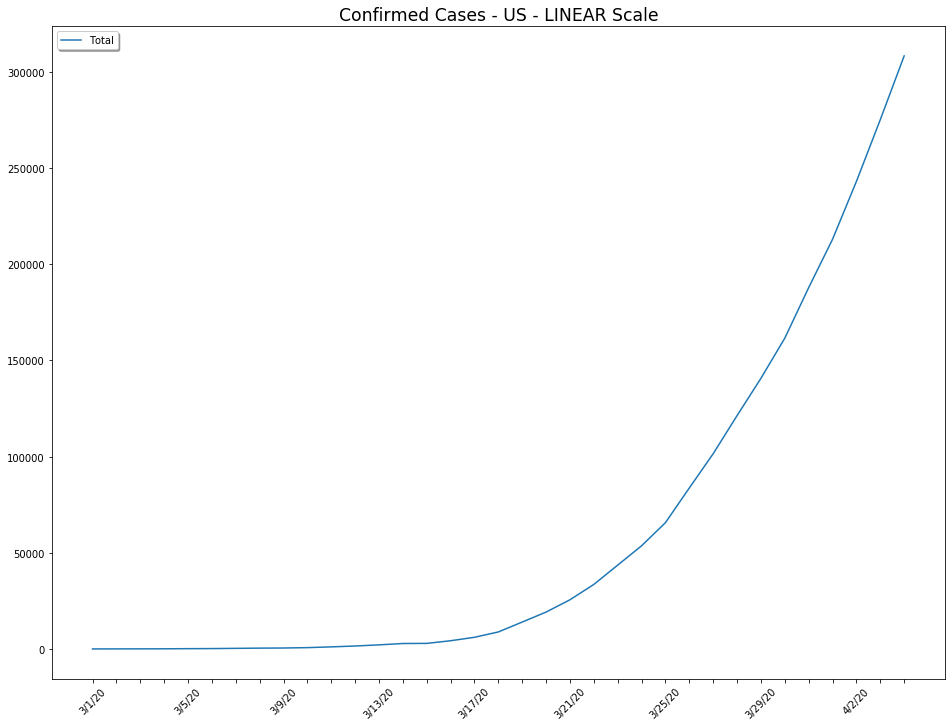

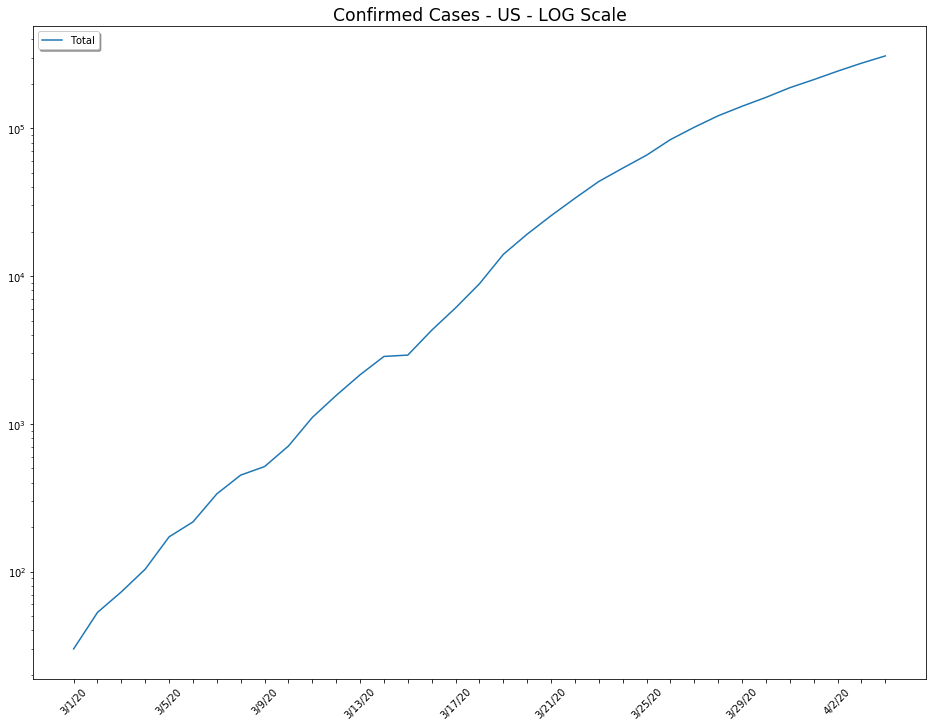

In [3]:
# Confirmed cases

# limits on the data - helps get rid of uncertainty in early data
counts = summary[start_date:]

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
ax.set_yscale('linear')
ax.plot(counts)
every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.legend(('Total',), shadow=True, loc='upper left')
plt.title('Confirmed Cases - US - LINEAR Scale', fontsize='xx-large')
plt.show()


fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.plot(counts)
every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.legend(('Total',), shadow=True, loc='upper left')
plt.title('Confirmed Cases - US - LOG Scale', fontsize='xx-large')
plt.show()

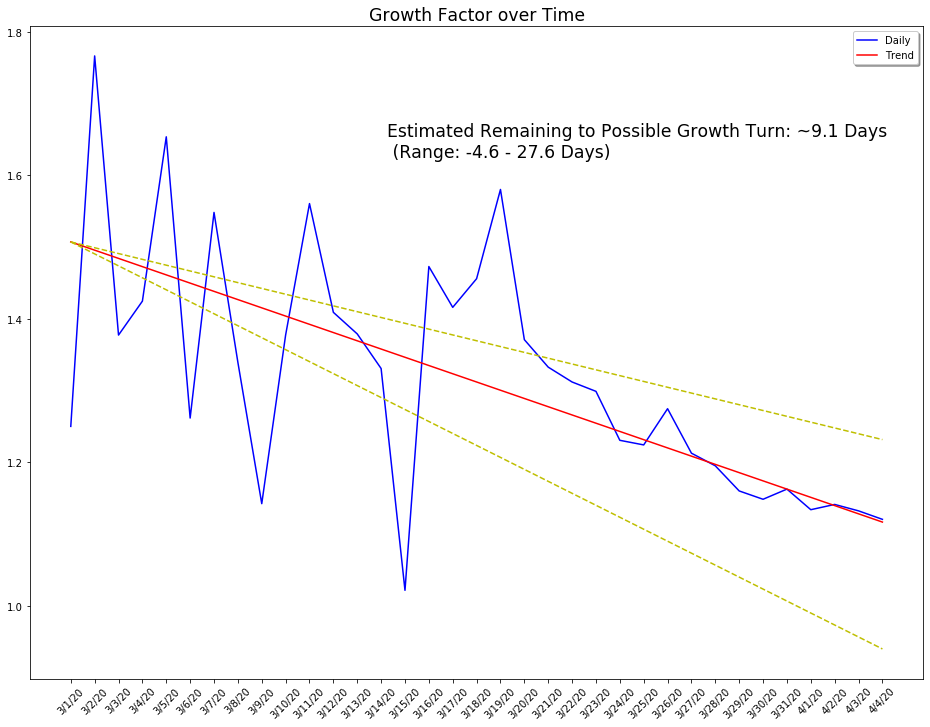

In [4]:
# Growth Factor Analysis

# Growth is calculated as (day / (day - 1))
growth = summary / summary.shift()
growth = growth.fillna(growth.median()) # get rid of NaNs
growth = growth[start_date:] # limit to drop out early data w/ lots of uncertainty

# linreg to establish the growth trend - DEPRECATED
lr = stats.linregress(range(growth.shape[0]), growth.values)
linreg = pd.Series([(lr[1] + lr[0] * x) for x in range(growth.shape[0])],
                   index=growth.index)

# theil slope to establish the growth trend
ts = stats.theilslopes(growth.values, range(growth.shape[0]), 0.95)
tslopes = pd.Series([(ts[1] + ts[0] * x) for x in range(growth.shape[0])], 
                    index=growth.index)
tslopes_lower = pd.Series([(ts[1] + ts[2] * x) for x in range(growth.shape[0])], 
                          index=growth.index)
tslopes_upper = pd.Series([(ts[1] + ts[3] * x) for x in range(growth.shape[0])], 
                          index=growth.index)

# How long until growth factor 1? 
days_to_one = ((1 - ts[1]) / ts[0]) - growth.shape[0]
days_to_one_low = ((1 - ts[1]) / ts[2]) - growth.shape[0]
days_to_one_hi = ((1 - ts[1]) / ts[3]) - growth.shape[0]
days_remaining = days_to_one 


# plot the growth factor and trend

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
ax.plot(growth, 'b-')
# ax.plot(linreg, 'g-')
ax.plot(tslopes, 'r-')
ax.plot(tslopes_upper, 'y--')
ax.plot(tslopes_lower, 'y--')
ax.text(.4, .8,
        'Estimated Remaining to Possible Growth Turn: ~{:.1f} Days\n (Range: {:.1f} - {:.1f} Days)'\
        .format(days_remaining, days_to_one_low, days_to_one_hi), 
        fontsize='xx-large', transform=ax.transAxes)
plt.xticks(rotation=45)
plt.legend(('Daily', 'Trend'), shadow=True, loc='upper right')
plt.title('Growth Factor over Time', fontsize='xx-large')
plt.show()